In [1]:
from pathlib import Path


from matplotlib import rcParams
from matplotlib.cm import rainbow
import math
import numpy as np
import pandas as pd


from math import sin, cos, sqrt, atan2, radians


from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import  linear_model

from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#Training
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


pd.set_option("display.max_columns", 100)




/kaggle/input/fare-classification/meta_data.csv
/kaggle/input/ml-dataset/ML data/sample_submission.csv
/kaggle/input/ml-dataset/ML data/test.csv
/kaggle/input/ml-dataset/ML data/train.csv


In [2]:
R = 6373.0

#lable encording
def encoding_label(label):
  if(label=='correct'):
    return 1
  else:
    return 0
#calculate hours
def calculate_hours(time):
    hours=time.total_seconds()
    return hours    
#calculate distance
def calculate_distance(coordinates):

#     print(coordinates['pick_lat'])
#     print(type(coordinates['pick_lat']))
    lat1 = math.radians(coordinates['pick_lat'])
    lon1 = math.radians(coordinates['pick_lon'])
    lat2 = math.radians(coordinates['drop_lat'])
    lon2 = math.radians(coordinates['drop_lon'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

#Finging outliers
def calculate_outliers(data,features):
    out_liers=[]
    for feature in features:
        column_data= data[[feature]]
#         column_data.head()
        print(feature)
        column_data.sort_values(by=[feature], inplace=True)
        
        q1, q3= np.percentile(column_data,[5,99.9])
        iqr = q3 - q1
#         lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr) 
        print(q1)
        print(q3)
#         outlier_list_col = column_data[(column_data < lower_bound) | (column_data > upper_bound)].index
        outlier_list_col = column_data[ (column_data > upper_bound)].index
        out_liers.extend(outlier_list_col)
    out_liers=Counter(out_liers)
    print(out_liers)
    out_liers = list(index for index,count in out_liers.items() if count > 2)
    column_data.head()
    return out_liers


def optimize_farevalue(fare): 
        fare_per_distance=fare['fare']/fare['distance']
        fare_per_distance_per_second= fare_per_distance/fare['time_difference']
        return fare_per_distance_per_second
def meter_waiting(fare):
        if(fare['meter_waiting_fare']==0):
            return fare['meter_waiting']
        return fare['meter_waiting']/fare['meter_waiting_fare']

Definition

In [3]:

train_data = pd.read_csv("/kaggle/input/ml-dataset/ML data/train.csv", index_col="tripid")
train_data["label"]=train_data["label"].apply(encoding_label).values
test_data = pd.read_csv("/kaggle/input/ml-dataset/ML data/test.csv", index_col="tripid")
submissionFormatData = pd.read_csv("/kaggle/input/ml-dataset/ML data/sample_submission.csv", index_col="tripid")
#training_data=train_data["label"]
# index_data=test_data["tripid"]
# train_data.head()
# Trainng_feature=train_data[]
# trainng_feature= train_data.loc[:,[0:12]]


# trainng_label.head()
# test_data.head()
# train_data.columns.values
# train_data.dropna()
# train_data.dropna()

Removing outliers

In [4]:
print(len(train_data.index))

17176


In [5]:
# train_data=train_data[(train_data['additional_fare']< 80)&(train_data['duration']< 330000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 28000)]

train_data=train_data[(train_data['additional_fare']< 220)&(train_data['duration']< 400000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 25097)]

# train_data=train_data[(train_data['additional_fare']< 100)&(train_data['duration']< 400000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 28000)]
#train_data=train_data[(train_data['duration']< 100000)&(train_data['meter_waiting'] <100000)&(train_data['meter_waiting_fare']<6000)&(train_data['meter_waiting_till_pickup']<4000)&(train_data['fare']< 8000)]

Text(0, 0.5, 'duration ($)')

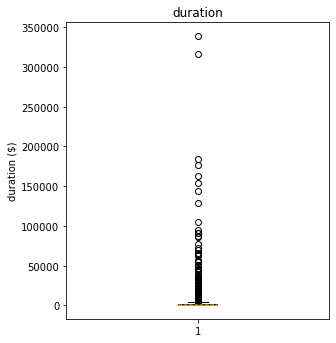

In [6]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['duration'], showmeans = True, meanline = True)
plt.title('duration')
plt.ylabel('duration ($)')

Text(0, 0.5, 'meter_waiting ($)')

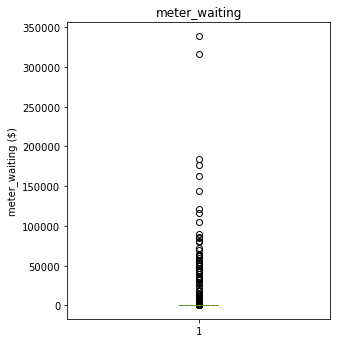

In [7]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['meter_waiting'], showmeans = True, meanline = True)
plt.title('meter_waiting')
plt.ylabel('meter_waiting ($)')

Text(0, 0.5, 'meter_waiting_fare ($)')

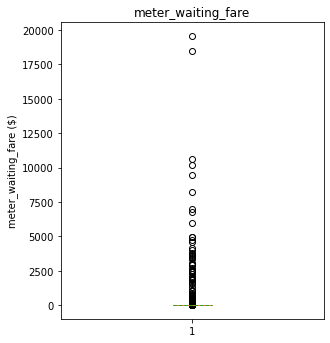

In [8]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['meter_waiting_fare'], showmeans = True, meanline = True)
plt.title('meter_waiting_fare')
plt.ylabel('meter_waiting_fare ($)')


Text(0, 0.5, 'meter_waiting_till_pickup ($)')

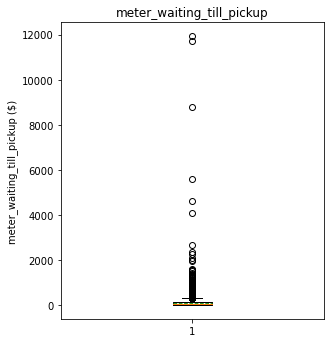

In [9]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['meter_waiting_till_pickup'], showmeans = True, meanline = True)
plt.title('meter_waiting_till_pickup')
plt.ylabel('meter_waiting_till_pickup ($)')

Text(0, 0.5, 'fare ($)')

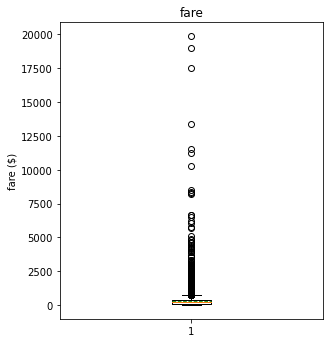

In [10]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['fare'], showmeans = True, meanline = True)
plt.title('fare')
plt.ylabel('fare ($)')

Text(0, 0.5, 'additional_fare ($)')

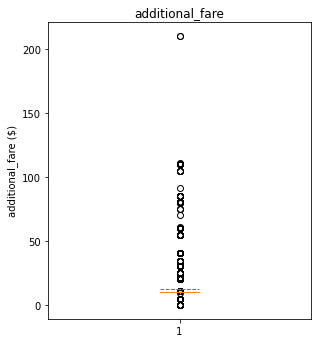

In [11]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['additional_fare'], showmeans = True, meanline = True)
plt.title('additional_fare')
plt.ylabel('additional_fare ($)')


In [12]:
print(len(train_data.index))

16960


In [13]:
# #Reemove NAN tuples
# train_data.dropna(inplace=True)
# #dropNAN columns from test list
# NANcolumns=test_data.columns[test_data.isna().any()].tolist()
# #remove tuples from submissionData
# submissionFormatData.drop(NANcolumns)
# test_data.dropna(inplace=True)

In [14]:
# # out_liers= calculate_outliers(train_data, ["duration","meter_waiting","meter_waiting_fare","fare","pick_lat","pick_lon","drop_lat","drop_lon"])
# # out_liers= calculate_outliers(train_data, ["additional_fare","duration","meter_waiting","meter_waiting_fare","fare"])
# out_liers= calculate_outliers(train_data, ["meter_waiting_fare"])
# out_liers
# train_data.drop(out_liers,inplace=True)

Data Preprocessing

In [15]:
lableList=[0,1]
for lable in lableList:
    train_data[(train_data['label']==lable)]['additional_fare'].fillna(train_data[(train_data['label']==lable)]['additional_fare'].mean(), inplace = True)
    train_data[(train_data['label']==lable)]['meter_waiting'].fillna( train_data[(train_data['label']==lable)]['meter_waiting'], inplace = True)
    train_data[(train_data['label']==lable)]['meter_waiting_fare'].fillna(train_data[(train_data['label']==lable)]['meter_waiting_fare'].mean(), inplace = True)
    train_data[(train_data['label']==lable)]['meter_waiting_till_pickup'].fillna( train_data[(train_data['label']==lable)]['meter_waiting_till_pickup'].mean(), inplace = True)
    train_data[(train_data['label']==lable)]['fare'].fillna(train_data[(train_data['label']==lable)]['fare'].mean(), inplace = True)
   

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
trainng_label= train_data["label"]
trainng_feature= train_data.loc[:,"additional_fare":"fare"]

In [17]:
trainng_feature.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30
189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02


In [18]:

trainng_feature['pickup_time'] = pd.to_datetime(trainng_feature['pickup_time'],format='%m/%d/%Y %H:%M')
trainng_feature['drop_time'] = pd.to_datetime(trainng_feature['drop_time'],format='%m/%d/%Y %H:%M')
test_data['pickup_time'] = pd.to_datetime(test_data['pickup_time'],format='%m/%d/%Y %H:%M')
test_data['drop_time'] = pd.to_datetime(test_data['drop_time'],format='%m/%d/%Y %H:%M')


trainng_feature['time_difference']=trainng_feature['drop_time']-trainng_feature['pickup_time']
trainng_feature['time_difference']=trainng_feature['time_difference'].apply(calculate_hours).values
test_data['time_difference']=test_data['drop_time']-test_data['pickup_time']
test_data['time_difference']=test_data['time_difference'].apply(calculate_hours).values

#calculate distance

# trainng_feature['time_difference']=trainng_feature['time_difference'].days
# trainng_feature['pyear']=trainng_feature['pickup_time'].dt.year 
# trainng_feature['pmonth']=trainng_feature['pickup_time'].dt.month 
# trainng_feature['pday']=trainng_feature['pickup_time'].dt.day
# trainng_feature['pdayofweek_num']=trainng_feature['pickup_time'].dt.dayofweek 
# trainng_feature['pHour'] = trainng_feature['pickup_time'].dt.hour 
# trainng_feature['pminute'] = trainng_feature['pickup_time'].dt.minute 




trainng_feature=trainng_feature.drop(['pickup_time','drop_time'],axis=1)
test_data=test_data.drop(['pickup_time','drop_time'],axis=1)
# trainng_feature['dyear']=trainng_feature['drop_time'].dt.year 
# trainng_feature['dmonth']=trainng_feature['drop_time'].dt.month 
# trainng_feature['dday']=trainng_feature['drop_time'].dt.day
# trainng_feature['ddayofweek_num']=trainng_feature['drop_time'].dt.dayofweek 
# trainng_feature['dHour'] = trainng_feature['drop_time'].dt.hour 
# trainng_feature['dminute'] = trainng_feature['drop_time'].dt.minute 
# test_data.isnull().sum()

#merginh two dataframes
trainng_feature["distance"]=trainng_feature[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1)
test_data["distance"]=test_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1)
#
# trainng_feature['fare']=trainng_feature.apply(optimize_farevalue,axis = 1)
# test_data['fare']=test_data.apply(optimize_farevalue,axis = 1)
# drop columns
trainng_feature=trainng_feature.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis=1)
test_data=test_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis=1)




In [19]:
trainng_feature.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,840.0,5.094369
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,780.0,3.169052
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1080.0,6.307375
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,600.0,0.862217
189129552,10.5,3407.0,182.0,0.0000,112.0,1065.02,3420.0,24.214638


In [20]:
# data_cleaner=[train_data['label'= 'correct'],train_data['label'= 'incorrect']]

    


In [21]:
trainng_feature.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,840.0,5.094369
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,780.0,3.169052
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1080.0,6.307375
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,600.0,0.862217
189129552,10.5,3407.0,182.0,0.0000,112.0,1065.02,3420.0,24.214638


In [22]:
#replace duration NAN values with time difference
trainng_feature.duration.fillna(trainng_feature.time_difference, inplace = True)
#calculate duration without immobile time
trainng_feature["duration"]=trainng_feature["duration"]-trainng_feature["meter_waiting"]
test_data["duration"]=test_data["duration"]-test_data["meter_waiting"]
#calculate fare without meter_waiting_fare
# trainng_feature["fare"]=trainng_feature["fare"]-trainng_feature["meter_waiting_fare"]
# test_data["fare"]=test_data["fare"]-test_data["meter_waiting_fare"]

trainng_feature.head()



,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.5,778.0,56.0,0.0000,64.0,270.32,840.0,5.094369
189125358,10.5,744.0,47.0,0.0000,134.0,197.85,780.0,3.169052
189125719,10.5,1007.0,80.0,0.0000,61.0,301.64,1080.0,6.307375
189127273,10.5,327.0,271.0,15.6638,68.0,82.30,600.0,0.862217
189129552,10.5,3225.0,182.0,0.0000,112.0,1065.02,3420.0,24.214638


In [23]:
# trainng_feature["fare"]=trainng_feature["fare"]-trainng_feature["additional_fare"]-trainng_feature["meter_waiting_fare"]
# trainng_feature["duration"]=trainng_feature["duration"]/(trainng_feature["fare"]- trainng_feature["meter_waiting_fare"])
# test_data["duration"]=test_data["duration"]/(test_data["fare"]-test_data["meter_waiting_fare"])
trainng_feature["duration"]=trainng_feature["duration"]/trainng_feature["fare"]
test_data["duration"]=test_data["duration"]/test_data["fare"]

trainng_feature["time_difference"]=trainng_feature["time_difference"]/trainng_feature["fare"]
test_data["time_difference"]=test_data["time_difference"]/test_data["fare"]

# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["meter_waiting_till_pickup"]/trainng_feature["fare"]
# test_data["meter_waiting_till_pickup"]=test_data["meter_waiting_till_pickup"]/test_data["fare"]

# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["distance"]
# test_data["meter_waiting_till_pickup"]=test_data["distance"]

# trainng_feature["fare"]=trainng_feature["fare"]/trainng_feature["distance"]
# test_data["fare"]=test_data["fare"]/test_data["distance"]

trainng_feature['meter_waiting']=trainng_feature.apply(meter_waiting,axis = 1)
test_data['meter_waiting']=test_data.apply(meter_waiting,axis = 1)

# trainng_feature["meter_waiting"]=trainng_feature["meter_waiting"]/3600
# test_data["meter_waiting"]=test_data["meter_waiting"]/3600




trainng_feature.head()


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.5,2.878070,56.000000,0.0000,64.0,270.32,3.107428,5.094369
189125358,10.5,3.760425,47.000000,0.0000,134.0,197.85,3.942381,3.169052
189125719,10.5,3.338417,80.000000,0.0000,61.0,301.64,3.580427,6.307375
189127273,10.5,3.973269,17.301038,15.6638,68.0,82.30,7.290401,0.862217
189129552,10.5,3.028112,182.000000,0.0000,112.0,1065.02,3.211207,24.214638


In [24]:
#feature engineering




trainng_feature.head()
# trainng_feature.isnull().sum()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.5,2.878070,56.000000,0.0000,64.0,270.32,3.107428,5.094369
189125358,10.5,3.760425,47.000000,0.0000,134.0,197.85,3.942381,3.169052
189125719,10.5,3.338417,80.000000,0.0000,61.0,301.64,3.580427,6.307375
189127273,10.5,3.973269,17.301038,15.6638,68.0,82.30,7.290401,0.862217
189129552,10.5,3.028112,182.000000,0.0000,112.0,1065.02,3.211207,24.214638


Check for outliers

In [25]:
# numerical_cols = trainng_feature.columns[trainng_feature.dtypes != "object"].values

In [26]:
# numerical_cols

In [27]:
# numeric_preprocessing_steps = Pipeline([
#     ('standard_scaler', StandardScaler()),
#     ('simple_imputer', SimpleImputer(strategy='mean'))
# ])

# preprocessor = ColumnTransformer(
#     transformers = [
#         ("numeric", numeric_preprocessing_steps, numerical_cols)
#     ],
#     remainder = "drop"
# )

Parameter tuning

In [28]:
# rf = RandomForestRegressor(random_state = 42)
# print('Parameters currently in use:\n')
# pprint(rf.get_params())

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}

param_grid = {
    'estimator__bootstrap': [True],
    'estimator__max_depth': [80, 90, 100, 110],
    'estimator__max_features': [2, 3],
    'estimator__min_samples_leaf': [3, 4, 5],
    'estimator__min_samples_split': [8, 10, 12],
    'estimator__n_estimators': [100, 200, 300, 1000]
}

param_test1 = {
 'estimator__max_depth':range(3,10,2),
 'estimator__min_child_weight':range(1,6,2)
}
param_test2 = {
 'estimator__max_depth':[2,3,4],
 'estimator__min_child_weight':[4,5,6]
}

param_test2a = {
 'estimator__max_depth':[4,6,8,10]
}

# param_test2b = {
#  'estimator__min_child_weight':[3,5,7,9]
# }
param_test2b = {
 'estimator__min_child_weight':[6,7,8]
}
# param_test2b = {
#  'estimator__min_child_weight':[10,12,14,16]
# }


param_test3 = {
 'estimator__gamma':[i/10.0 for i in range(0,5)]
}
param_test4 = {
 'estimator__subsample':[i/10.0 for i in range(6,10)],
 'estimator__colsample_bytree':[i/10.0 for i in range(6,10)]
}
param_test5 = {
 'estimator__subsample':[i/100.0 for i in range(75,90,5)],
 'estimator__colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
param_test6 = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
} 
#0.006737947
param_test7 = {
 'estimator__reg_alpha':[0,0.01,0.1, 0.5, 0.05]
}
# param_test7 = {
#  'estimator__reg_alpha':[0, 0.00006737947,0.00033689735, 0.0006737947, 0.0033689735]
# }

param_test8 = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'estimator__reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
} 
param_test8b = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'estimator__reg_lambda':[100, 100.1, 99,99.9, 101]
} 
param_test9 = {
 'estimator__base_score':[i/10.0 for i in range(0,10)]
 
} 
param_test9b = {
 'estimator__base_score':[i/100.0 for i in range(0,10)]
 
} 




pprint(random_grid)

{'estimator__bootstrap': [True, False],
 'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'estimator__max_features': ['auto', 'sqrt'],
 'estimator__min_samples_leaf': [1, 2, 4],
 'estimator__min_samples_split': [2, 5, 10],
 'estimator__n_estimators': [200,
                             400,
                             600,
                             800,
                             1000,
                             1200,
                             1400,
                             1600,
                             1800,
                             2000]}


In [30]:
# estimator=MultiOutputClassifier(

# estimator=RandomForestClassifier(     
#          n_estimators = 1400,
#          min_samples_split= 5,
#          min_samples_leaf= 1,
#          max_features = 'sqrt',
#          max_depth = 30,
#          bootstrap = True
                                    
                                    
#     )
# )

#fail
# estimator=xgb.XGBClassifier(
#          reg_alpha=0,
#          learning_rate =0.1,
#          n_estimators=1000,
# #          max_depth=3,
# #          min_child_weight=1,
#          max_depth=3,
#          min_child_weight=6,
#          gamma=0,
#          subsample=0.6,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread=4,
#          scale_pos_weight=1,
#          seed=27
       
#         )

#newone # not optimized well
# estimator=xgb.XGBClassifier(
#      reg_alpha = 0.00033689735,
#      learning_rate = 0.01,
#      n_estimators = 1000,
#      max_depth=3,
#      min_child_weight=2,
#      gamma=0.4,
#      subsample=0.8,
#      colsample_bytree=0.75,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
#     )

#2ndTime
# estimator=xgb.XGBClassifier(
#          reg_alpha=0,
#          learning_rate =0.1,
#          n_estimators=1000,
# #          max_depth=3,
# #          min_child_weight=1,
#          max_depth=4,
#          min_child_weight=3,
#          gamma=0,
#          subsample=0.6,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread=4,
#          scale_pos_weight=1,
#          seed=27
       
#         )
#3rdTime 
# estimator=xgb.XGBClassifier(
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=3,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.6,
#      colsample_bytree=0.7,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27)
# 4thTime current one
# estimator= xgb.XGBClassifier(
#      reg_alpha=1,
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=3,
#      min_child_weight=6,
#      gamma=0,
#      subsample=0.85,
#      colsample_bytree=0.75,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
# )
#current one
estimator = xgb.XGBClassifier (
#      learning_rate =0.1,
#      n_estimators=200,
#      max_depth=2,
#      min_child_weight=5,
     gamma=0,
#      subsample=0.9,
#      colsample_bytree=0.9,
      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27,
#      reg_alpha = 0,
#      reg_lambda = 1
      

)
#initialOne
# estimator= xgb.XGBClassifier(
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=5,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
# )
# basecore=.1
# esti=200
#Firstime
# estimator=RandomForestClassifier(     
# #          n_estimators = 1400,
# #          min_samples_split= 5,
# #          min_samples_leaf= 1,
# #          max_features = 'sqrt',
# #          max_depth = 30,
# #          bootstrap = True
#             max_depth=90,
#             max_features=3,
#             min_samples_leaf=3,
#             min_samples_split=8,
#             n_estimators=1000,
#             bootstrap=True,
#             random_state=45
                                    
#     )

In [31]:
full_pipeline = Pipeline([
#     ("preprocessor", preprocessor),
    ("estimator", estimator),
])
pprint(full_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'estimator', 'estimator__objective', 'estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__gpu_id', 'estimator__importance_type', 'estimator__interaction_constraints', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__monotone_constraints', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__num_parallel_tree', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__subsample', 'estimator__tree_method', 'estimator__validate_parameters', 'estimator__verbosity'])


In [32]:
# print(type(trainng_label))
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(full_pipeline, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring ='f1')
# Fit the random search model
# rf_random.fit( trainng_feature, trainng_label)

#XgBoosting

# data_dmatrix = xgb.DMatrix(data=trainng_feature,label=trainng_label)

# params = {"estimator__objective":"binary:logistic",'estimator__colsample_bytree': 0.3,'estimator__learning_rate': 0.1,
#                 'estimator__max_depth': 5, 'estimator__alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

# cv_results.head()

In [33]:
# grid_search = GridSearchCV(full_pipeline, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2,scoring ='f1')
# grid_search.fit( trainng_feature, trainng_label)

# grid_search = GridSearchCV(full_pipeline, param_grid =param_test9b,cv = 5, n_jobs = -1, verbose = 2,scoring ='f1')
# grid_search.fit( trainng_feature, trainng_label)

In [34]:
# rf_random.best_params_
# grid_search.best_estimator_
# grid_search.best_params_
# grid_search.grid_scores_, 
# grid_search.best_params_, grid_search.best_score_

In [35]:
full_pipeline

Pipeline(memory=None,
         steps=[('estimator',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=0, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=False,
                            

Creating the dataset

In [36]:
X_train, X_eval, y_train, y_eval = train_test_split(
    trainng_feature,
    trainng_label,
    test_size=0.33,
    shuffle=True,
    stratify= trainng_label,
    random_state=6
)
# X_train.head()

y_train.shape

(11363,)

Train the model

In [37]:
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict(X_eval)
preds


array([1, 1, 1, ..., 1, 1, 1])

In [38]:
print("test_probas[0].shape", preds.shape)

test_probas[0].shape (5597,)


In [39]:
y_preds = pd.DataFrame(
    {
        "prediction": preds
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5597, 1)


,prediction
tripid,
189978643,1
190044131,1
200707033,1
199928577,1
203594678,1


Test model

In [40]:
f1_score(y_eval, y_preds, average=None)

array([0.75139353, 0.97834321])

In [41]:
full_pipeline.fit(trainng_feature, trainng_label)

Pipeline(memory=None,
         steps=[('estimator',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method=None,
                               validate_parameters=False, verbosity=None))],
         verbose=False)

In [42]:
test_probas = full_pipeline.predict(test_data)
test_probas

array([1, 0, 1, ..., 1, 1, 1])

In [43]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_data.index.values, 
                              submissionFormatData.index.values)


submissionFormatData["prediction"]=test_probas
submissionFormatData.head()

submissionFormatData.to_csv('my_submission.csv', index=True)

Show output

In [44]:
!head my_submission.csv

tripid,prediction
213284604,1
213286352,0
213293973,1
213294622,1
213298687,1
213299545,0
213302332,1
213302671,1
213305594,1
